# An extended evaluation of the results with various null-modelling appoaches

In [1]:
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc_file_defaults()
from sklearn.preprocessing import StandardScaler
import nilearn
from tqdm import tqdm
from connattractor import network, analysis
%load_ext autoreload
%autoreload 1
%aimport connattractor.network
%aimport connattractor.analysis

## Fractional occupancy

### load empirical data

In [3]:
import os
# load resting state data
_fd_thr = 0.15
_perc_scrub_thr = 0.5

# load data
from glob import glob
all_ts = []
root_dir = '../data_in/ex_timeseries/'
for f in glob(root_dir + 'bochum-???.tsv'):
    path, filename = os.path.split(f)
    ts = pd.read_csv(f, sep='\t').iloc[:, 1:].values
    ts = StandardScaler().fit_transform(ts)
    fd = pd.read_csv(path + '/FD_' + os.path.splitext(filename)[0] + '.txt', sep=',').values.flatten()
    fd = np.hstack(([0], fd))

    if np.sum(fd>_fd_thr)/len(fd) < _perc_scrub_thr:
        all_ts.append(ts[fd<_fd_thr])
    else:
        print('perc. scrubbed:', np.sum(fd>_fd_thr)/len(fd))

all_ts = np.vstack([i for i in all_ts])

perc. scrubbed: 0.515


### fcHNN

In [47]:
simresults_all = {}
hopfield_embeddings_all = {}

for noise in [0.33, 0.35, 0.37, 0.39]:
    simresults_all[noise] = analysis.simulate_activations(mtx.values, noise_coef=noise, 
                                                          num_iter=100000, beta=0.04, random_state=2023)
    hopfield_embeddings_all[noise] = analysis.create_embeddings(simresults_all[noise], 
                                                                attractor_sample=len(all_ts),random_state=2023)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7200/7200 [06:52<00:00, 17.46it/s]


In [48]:
# time spent in state
emp_attractor_states = {}
for noise in [0.33, 0.35, 0.37, 0.39]:
    tmp = []
    for s in tqdm(range(all_ts.shape[0])):
        tmp.append(hopfield_embeddings_all[noise].hopnet.update(all_ts[s, :])[0])
    emp_attractor_states[noise] = np.array(tmp)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7200/7200 [06:51<00:00, 17.51it/s]


In [160]:
emp_attractor_labels = {}
for noise in [0.33, 0.35, 0.37, 0.39]:
    emp_attractor_labels[noise] = []
    for i in range(emp_attractor_states[noise].shape[0]):
        for key in [0,1,2,3]:
            #print(hopfield_embeddings_all[noise].attractors[key], emp_attractor_states[noise][i,:])
            if np.allclose(hopfield_embeddings_all[noise].attractors[key], emp_attractor_states[noise][i,:], atol=0.001):
                emp_attractor_labels[noise].append(key)
                

## Now we use a phase randomized null model to generate a null-distribution for occupancy-similarity

noise: 0.33 stat: 57.99319130667239  p = 0.0


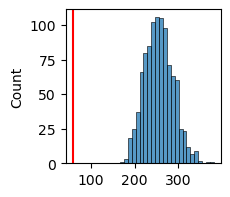

noise: 0.35 stat: 25.25857211267605  p = 0.0


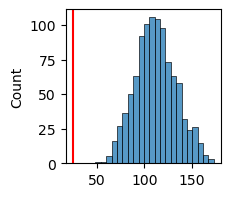

noise: 0.37 stat: 12.33674137857482  p = 0.0


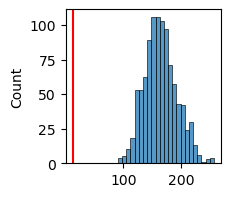

noise: 0.39 stat: 9.787634156887727  p = 0.0


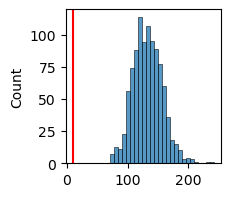

In [51]:
random = np.random.default_rng(42)

def phase_randomization(data):
    # Get the shape of the data
    num_samples, num_features = data.shape 
    # Create a copy of the data
    randomized_data = np.copy(data)
    # Iterate over each time-frame
    for i in range(num_samples):
        data = randomized_data[i, :]
        fft_data = np.fft.fft(data)
        phase = random.permutation(np.angle(fft_data)) # same perm for all region
        randomized_data[i, :] = np.real(np.fft.ifft(np.abs(fft_data) * np.exp(1j * phase)))
    
    return randomized_data

from scipy.stats import chisquare

n_perm =1000

for noise in [0.33, 0.35, 0.37, 0.39]:
   
    # simulated
    sim_attractor_states = hopfield_embeddings_all[noise].attractor_sample
    label_sim, counts_sim = np.unique(sim_attractor_states, return_counts=True)
   
    # empirical
    label_emp, counts_emp = np.unique(emp_attractor_labels[noise], return_counts=True)
    true_test_stat = chisquare(counts_sim, counts_emp).statistic
   
    # null distribution for empirical
    test_stat_null = []
    for i in range(n_perm):
        
        all_ts_phaserand = phase_randomization(all_ts)
        
        embedded = hopfield_embeddings_all[noise].embedding_model.transform(all_ts_phaserand)[:, :2]
        attractor_labels = hopfield_embeddings_all[noise].attractor_model.predict(embedded)
        label_emp_shuffled, counts_emp_shuffled = np.unique(attractor_labels, return_counts=True)
        test_stat_null.append(chisquare(counts_sim, counts_emp_shuffled).statistic) # does this differ from empirical data?
    plt.figure(figsize=(2,2))
    sns.histplot(test_stat_null)
    plt.axvline(true_test_stat, color='red')
    print('noise:', noise, 'stat:', true_test_stat, ' p =', np.sum(np.array(test_stat_null) < true_test_stat) / n_perm)
    plt.show()

### Fractional occupancy is predicted for real data significantly better then for spatially phase randomized null data

## Another null model: sampling from a multivariate normal.

noise: 0.33 stat: 91.88249069188912  p = 0.887


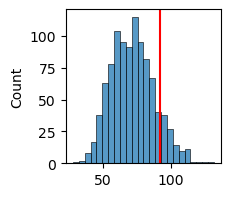

noise: 0.35 stat: 42.12373060169628  p = 0.762


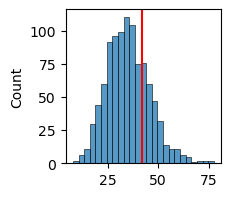

noise: 0.37 stat: 21.565370837595296  p = 0.015


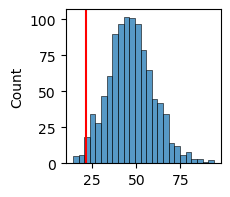

noise: 0.39 stat: 6.92166322039787  p = 0.002


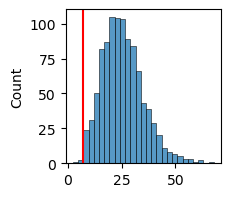

In [164]:
random = np.random.default_rng(42)

connfile = '../data_in/ex_connectome_partial_correlation.csv'
mtx = pd.read_csv(connfile).iloc[:, 1:]

from scipy.stats import chisquare

n_perm =1000

for noise in [0.33, 0.35, 0.37, 0.39]:
   
    # simulated
    sim_states = hopfield_embeddings_all[noise].state_sample
    sim_embedded = hopfield_embeddings_all[noise].embedding_model.transform(sim_states)[:, :2]
    sim_attractor_states = hopfield_embeddings_all[noise].attractor_sample
    label_sim, counts_sim = np.unique(sim_attractor_states, return_counts=True)
    
    label_emp, counts_emp = np.unique(emp_attractor_labels[noise], return_counts=True)
    true_test_stat = chisquare(counts_sim, counts_emp).statistic # the higher the stat the bigger the diff
   
    # null distribution for simulated
    test_stat_null = []
    for i in range(n_perm):
        
        all_ts_multivariate_normal = random.multivariate_normal(mean=np.repeat(0, mtx.shape[0]), 
                                                                cov=mtx.values, 
                                                                size=all_ts.shape[0])
        
        embedded = hopfield_embeddings_all[noise].embedding_model.transform(all_ts_multivariate_normal)[:, :2]
        # multivariate normal knows about the mean and std of the original distribution
        # we must give equal chances: rescale it to have the same range as the fcHNN simulated data
        embedded = (((embedded-np.mean(embedded)) / np.std(embedded)) * np.std(sim_embedded))+ np.mean(sim_embedded)
        attractor_labels = hopfield_embeddings_all[noise].attractor_model.predict(embedded)
        label_sim_null, counts_sim_null = np.unique(attractor_labels, return_counts=True)
        test_stat_null.append(chisquare(counts_sim_null, counts_emp).statistic) # does this differ from empirical data?
    
    plt.figure(figsize=(2,2))
    sns.histplot(test_stat_null)
    plt.axvline(true_test_stat, color='red')
    print('noise:', noise, 'stat:', true_test_stat, ' p =', np.sum(np.array(test_stat_null) < true_test_stat) / n_perm)
    plt.show()

### Fractional occupancy is predicted significantly better by fcHNN then by multivariate normal null data (with the functional covariance matrix) only with sigma=0.39